## Imports and model initialization

In [28]:
%load_ext autoreload
%autoreload 2

import csv
from datetime import datetime
import math
import os
from pathlib import Path
import pickle

import kipoi
from kipoiseq.dataloaders import SeqIntervalDl
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn import isotonic as iso
import seaborn as sns
from tqdm.notebook import tqdm
from utils import detect_device

import bpnet
from bpnet.datasets import StrandedProfile
from bpnet.dataspecs import DataSpec, TaskSpec
from bpnet.utils import create_tf_session
from bpnet.utils import read_json
from bpnet.seqmodel import SeqModel
from bpnet.plot.evaluate import plot_loss, regression_eval

from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pwd

/home/stephenmalina/project/src


In [3]:
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
output_dir = f'/home/stephenmalina/dev/an1lam/deepmr/dat/res-bpnet-{timestamp}'
feature_names = ['Oct4', 'Sox2', 'Nanog', 'Klf4']
n_bins = 10

In [4]:
os.makedirs(output_dir, exist_ok=True)

# Loading BPNet

In [5]:
class Ensemble:
    def __init__(self, model_base_dir, n_reps=5):
        models = []
        for i in range(n_reps):
            models.append(SeqModel.from_mdir(os.path.join(model_base_dir, str(i))))
        self.models = models

    def predict(self, seqs):
        preds = {}
        for model in self.models:
            model_preds = model.predict(seqs)
            for key, preds_ in model_preds.items():
                preds.setdefault(key, []).append(preds_.mean(-1))
        return {k: np.stack(v) for k, v in preds.items()}

In [6]:
model_base_dir = "/home/stephenmalina/project/dat/res-bpnet-training-2020-09-02-16-18-50/output_ensemble"

In [7]:
model_dir = Path(model_base_dir)

In [8]:
create_tf_session(0)
clear_output()

In [9]:
model = Ensemble(model_base_dir)
clear_output()

# Loading data

In [10]:
!cat {model_base_dir}/0/evaluation.valid.json

{
  "valid-peaks": {
    "Oct4/profile/binsize=1/auprc": 0.174503907210406,
    "Oct4/profile/binsize=1/random_auprc": 0.002968693730871131,
    "Oct4/profile/binsize=1/n_positives": 49840,
    "Oct4/profile/binsize=1/frac_ambigous": 0.07240139387999564,
    "Oct4/profile/binsize=1/imbalance": 0.002925521986142981,
    "Oct4/profile/binsize=10/auprc": 0.47671418115881486,
    "Oct4/profile/binsize=10/random_auprc": 0.03541463757849398,
    "Oct4/profile/binsize=10/n_positives": 39957,
    "Oct4/profile/binsize=10/frac_ambigous": 0.3622726777741479,
    "Oct4/profile/binsize=10/imbalance": 0.03411483457844183,
    "Oct4/counts/mse": 0.32489997148513794,
    "Oct4/counts/var_explained": 0.3644736409187317,
    "Oct4/counts/pearsonr": 0.6039534407707656,
    "Oct4/counts/spearmanr": 0.5689491091522799,
    "Oct4/counts/mad": 0.4609355032444,
    "Sox2/profile/binsize=1/auprc": 0.38153955490138125,
    "Sox2/profile/binsize=1/random_auprc": 0.00560025646079356,
    "Sox2/profile/binsize=1/

In [11]:
gin_config = read_json(os.path.join(model_base_dir, str(0), 'config.gin.json'))

In [12]:
ds = DataSpec.load(os.path.join(model_base_dir, '0', 'dataspec.yml'))
tasks = list(ds.task_specs)
tasks

['Oct4', 'Sox2', 'Nanog', 'Klf4']

In [13]:
dl_valid = StrandedProfile(ds, 
                           incl_chromosomes=gin_config['bpnet_data.valid_chr'], 
                           peak_width=gin_config['bpnet_data.peak_width'],
                           seq_width=gin_config['bpnet_data.seq_width'],
                           shuffle=False)

In [14]:
valid = dl_valid.load_all(num_workers=8)

100%|██████████| 915/915 [01:35<00:00,  9.62it/s]


In [15]:
valid['inputs'].keys(), valid['targets'].keys(), valid['metadata']

(dict_keys(['seq']),
 dict_keys(['Oct4/profile', 'Sox2/profile', 'Nanog/profile', 'Klf4/profile', 'Oct4/counts', 'Sox2/counts', 'Nanog/counts', 'Klf4/counts']),
 {'range': {'chr': array(['chr3', 'chr2', 'chr3', ..., 'chr3', 'chr4', 'chr4'], dtype='<U4'),
   'start': array([122145078,  52071743,  96334135, ...,   3672964, 127020434,
          124905354]),
   'end': array([122146078,  52072743,  96335135, ...,   3673964, 127021434,
          124906354]),
   'id': array([    0,     1,     2, ..., 29274, 29275, 29276]),
   'strand': array(['.', '.', '.', ..., '.', '.', '.'], dtype='<U1')},
  'interval_from_task': array(['Oct4', 'Oct4', 'Oct4', ..., 'Klf4', 'Klf4', 'Klf4'], dtype='<U5')})

## Checking model calibration

In [16]:
cols = [f'{feature_name}/counts' for feature_name in feature_names]

In [17]:
valid['inputs']['seq'].shape

(29277, 1000, 4)

In [18]:
valid_seqs = valid['inputs']['seq']
valid_labels = valid['targets']

In [19]:
preds = model.predict(valid['inputs']['seq'])

In [20]:
preds.keys()

dict_keys(['Oct4/profile', 'Oct4/counts', 'Sox2/profile', 'Sox2/counts', 'Nanog/profile', 'Nanog/counts', 'Klf4/profile', 'Klf4/counts'])

In [21]:
means = {col: np.mean(preds[col], axis=0) for col in cols}
stds = {col: np.std(preds[col], axis=0) for col in cols}

estimated_cum_probs = {}
for col in cols:
    y_mean_stds = zip(valid_labels[col].mean(-1), means[col], stds[col])
    estimated_cum_probs[col] = np.array(
        [norm.cdf(y, loc=mean, scale=std) for (y, mean, std) in y_mean_stds]
    )

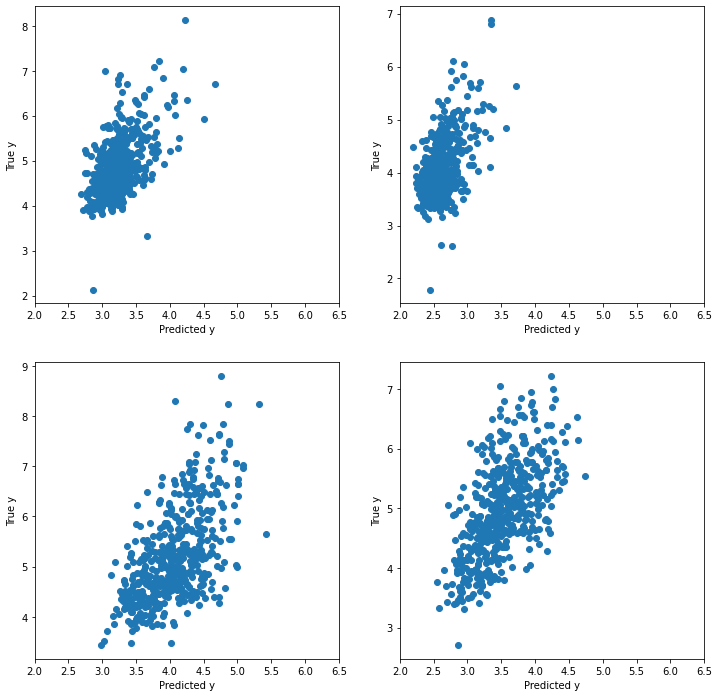

In [22]:
np.random.seed(17)
n_samples = 500
idxs = np.arange(len(valid_seqs))
np.random.shuffle(idxs)
sample_idxs = idxs[:n_samples]

fig, axs = plt.subplots(len(cols) // 2, 2, figsize=(12, 12))


for i, col in enumerate(cols):
    sample_means = means[col][sample_idxs]
    sample_labels = valid_labels[col].mean(-1)[sample_idxs]
    ax = axs[i // 2, i % 2]
    ax.scatter(sample_means, sample_labels)
    ax.set_xlim(2, 6.5)
    ax.set_xlabel("Predicted y")
    ax.set_ylabel("True y")

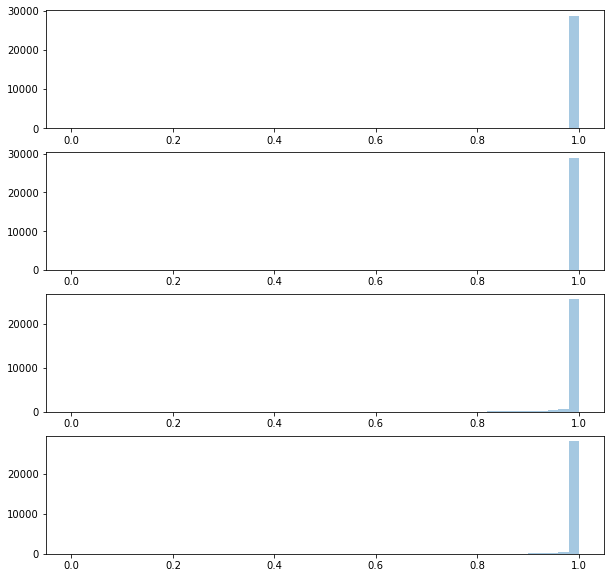

In [23]:
fig, axs = plt.subplots(len(cols), 1, figsize=(10, 10))
for i, col in enumerate(cols):
    sns.distplot(estimated_cum_probs[col], ax=axs[i], kde=False)

In [24]:
thresholds = np.linspace(0, 1, num=n_bins+1)
thresholds = thresholds[1:] # Trim 0
thresholds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [91]:
p_hats = {}
for col in cols:
    p_hats[col] = []
    for p in thresholds:
        ep = estimated_cum_probs[col]
        p_hat = len(ep[ep <= p]) / len(estimated_cum_probs[col])
        p_hats[col].append(p_hat)

In the following calibration plots, $ p_j $ is one of the $ n $ thresholds determined based on the hyperparameter for calibration, $ n $. On the other hand, $ \hat{p}_j $ represents the observed frequency of probabilities $ \leq p_j $ in the validation set. Perfect calibration would manifest as a straight line on these graphs. Conceptually, perfect calibration implies that our family of CDFs' predictions together constitute a well-distributed set of probabilities. That is, $ p_j $ fraction of the validation data should have probability $ \leq p_j $.

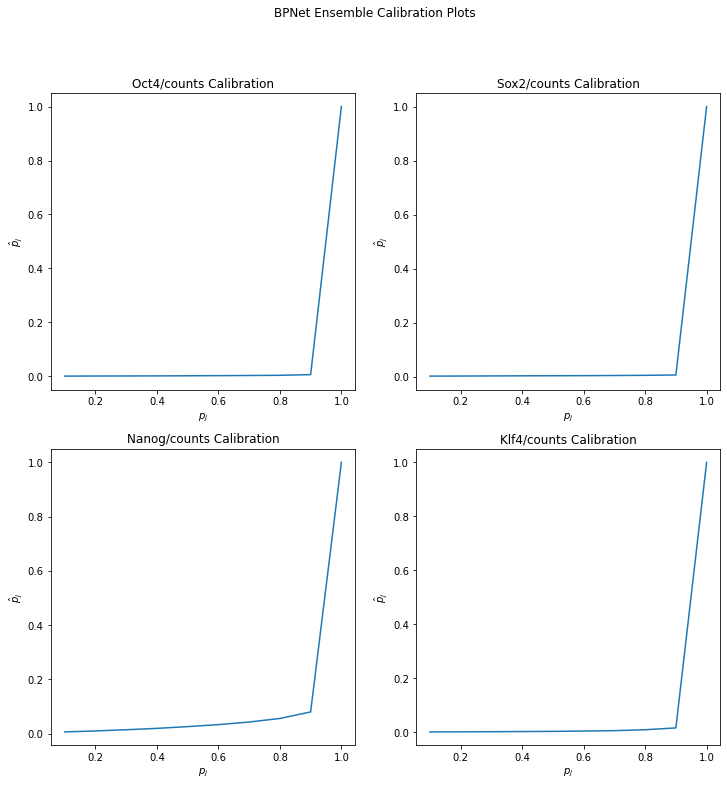

In [26]:
fig, axs = plt.subplots(len(cols) // 2, 2, figsize=(12, 12))
fig.suptitle("BPNet Ensemble Calibration Plots")
for i, col in enumerate(cols):
    ax = axs[i // 2, i % 2]
    sns.lineplot(thresholds, p_hats[col], ax=ax)
    ax.set_xlabel("$ p_j $")
    ax.set_ylabel("$ \hat{p}_j $")
    ax.set_title(f"{col} Calibration")

# Recalibration
The above clearly illustrates that a BPNet model trained to minimize MSE is not calibrated with respect to its validation set. In this section, we apply the method described by Ermon et al to try and improve the calibration of the BPNet model.

In [52]:
np.random.seed(17)
idxs = np.arange(len(valid_seqs))
np.random.shuffle(idxs)
n_samples = len(valid_seqs) // 2
recalibration_idxs = idxs[:n_samples]
recalibration_seqs = valid_seqs[recalibration_idxs]
recalibration_means = {k: v[recalibration_idxs] for k, v in means.items()}
recalibration_stds = {k: v[recalibration_idxs] for k, v in stds.items()}
recalibration_labels = {k: v[recalibration_idxs].mean(-1) for k, v in valid_labels.items()}

calibration_idxs = idxs[n_samples:]
calibration_means = {k: v[calibration_idxs] for k, v in means.items()}
calibration_stds = {k: v[calibration_idxs] for k, v in stds.items()}
calibration_labels = {k: v[calibration_idxs].mean(-1) for k, v in valid_labels.items()}

In [53]:
recalibration_dataset = {}
for col in cols:
    estimated_cum_probs_ = estimated_cum_probs[col][recalibration_idxs]
    
    cum_probs = []
    for p in estimated_cum_probs_:
        p_hat = len(estimated_cum_probs_[estimated_cum_probs_ <= p]) / float(len(estimated_cum_probs_))
        cum_probs.append(p_hat)
    
    recalibration_dataset[col] = (estimated_cum_probs_, np.array(cum_probs))

In [54]:
recalibration_models = {}
for col in cols:
    y_hat, y_true = recalibration_dataset[col]
    iso_regression = iso.IsotonicRegression(y_min=0, y_max=1).fit(y_hat, y_true)
    recalibration_models[col] = iso_regression

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/opt/conda/lib/p

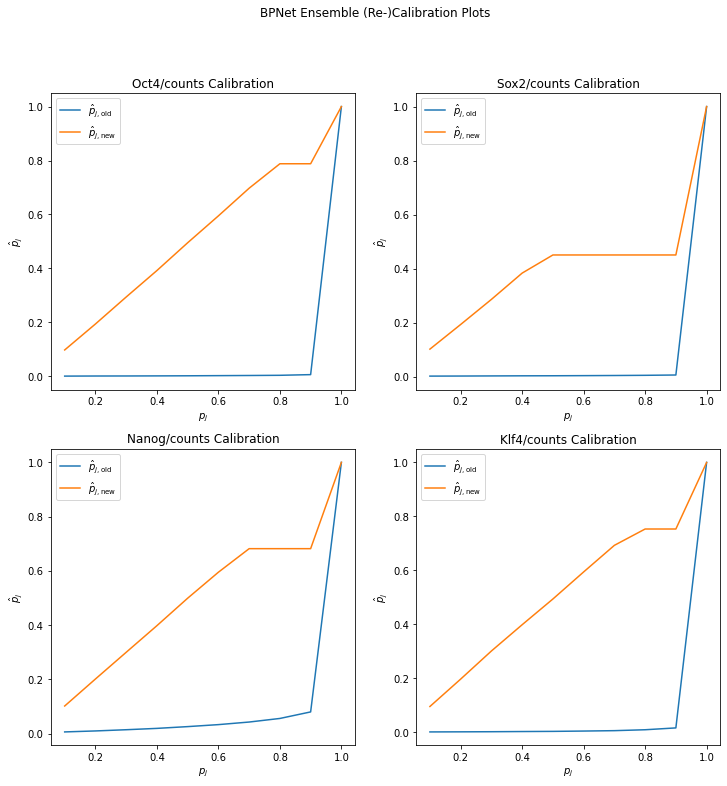

In [94]:
p_hats_new = {}
for col in cols:
    p_hats_new[col] = []
    for p in thresholds:
        ep = recalibration_models[col].predict(estimated_cum_probs[col][calibration_idxs])
        p_hat = len(ep[ep <= p]) / len(calibration_idxs)
        p_hats_new[col].append(p_hat)
        
fig, axs = plt.subplots(len(cols) // 2, 2, figsize=(12, 12))
fig.suptitle("BPNet Ensemble (Re-)Calibration Plots")
for i, col in enumerate(cols):
    ax = axs[i // 2, i % 2]
    sns.lineplot(thresholds, p_hats[col], ax=ax)
    sns.lineplot(thresholds, p_hats_new[col], ax=ax)

    ax.set_xlabel("$ p_j $")
    ax.set_ylabel("$ \hat{p}_j $")
    ax.legend(('$ \hat{p}_{j, \\mathrm{old}} $', '$ \hat{p}_{j, \\mathrm{new}} $'))
    ax.set_title(f"{col} Calibration")